# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [251]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path
import time

#### Default Datentyp

In [52]:
torch.set_default_dtype(torch.float64)

#### Plot Style

In [272]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [143]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.0395
Epoch 1/200, Iteration 2/12, Loss: 0.3574
Epoch 1/200, Iteration 3/12, Loss: 1.1179
Epoch 1/200, Iteration 4/12, Loss: 0.1646
Epoch 1/200, Iteration 5/12, Loss: 0.2872
Epoch 1/200, Iteration 6/12, Loss: 0.3813
Epoch 1/200, Iteration 7/12, Loss: 0.4107
Epoch 1/200, Iteration 8/12, Loss: 0.2869
Epoch 1/200, Iteration 9/12, Loss: 0.1560
Epoch 1/200, Iteration 10/12, Loss: 0.0860
Epoch 1/200, Iteration 11/12, Loss: 0.1286
Epoch 1/200, Iteration 12/12, Loss: 0.1168
Epoch 1/200, Iteration 13/12, Loss: 0.1032
Train Error: 
 Accuracy: 56.88%, Avg loss: 0.079964, MRE: 0.201752, MAE: 0.031196 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.073887, MRE: 0.168620, MAE: 0.031288 

Epoch 2/200, Iteration 1/12, Loss: 0.0924
Epoch 2/200, Iteration 2/12, Loss: 0.0887
Epoch 2/200, Iteration 3/12, Loss: 0.0594
Epoch 2/200, Iteration 4/12, Loss: 0.0780
Epoch 2/200, Iteration 5/12, Loss: 0.1078
Epoch 2/200, Iteration 6/12, Loss: 0.0628
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 82.88%, Avg loss: 0.004497, MRE: 0.038285, MAE: 0.006107 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.004625, MRE: 0.033818, MAE: 0.005723 

Epoch 13/200, Iteration 1/12, Loss: 0.0037
Epoch 13/200, Iteration 2/12, Loss: 0.0052
Epoch 13/200, Iteration 3/12, Loss: 0.0060
Epoch 13/200, Iteration 4/12, Loss: 0.0052
Epoch 13/200, Iteration 5/12, Loss: 0.0047
Epoch 13/200, Iteration 6/12, Loss: 0.0050
Epoch 13/200, Iteration 7/12, Loss: 0.0038
Epoch 13/200, Iteration 8/12, Loss: 0.0032
Epoch 13/200, Iteration 9/12, Loss: 0.0069
Epoch 13/200, Iteration 10/12, Loss: 0.0033
Epoch 13/200, Iteration 11/12, Loss: 0.0040
Epoch 13/200, Iteration 12/12, Loss: 0.0049
Epoch 13/200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002103, MRE: 0.029793, MAE: 0.004879 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001823, MRE: 0.023218, MAE: 0.004807 

Epoch 14/200, Iteration 1/12, Loss: 0.0025
Epoch 14/200, Iteration 2/12, Loss: 0.0059
Epoch 14/200, Itera

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.002049, MRE: 0.025606, MAE: 0.003827 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001275, MRE: 0.017899, MAE: 0.003228 

Epoch 25/200, Iteration 1/12, Loss: 0.0014
Epoch 25/200, Iteration 2/12, Loss: 0.0017
Epoch 25/200, Iteration 3/12, Loss: 0.0015
Epoch 25/200, Iteration 4/12, Loss: 0.0015
Epoch 25/200, Iteration 5/12, Loss: 0.0012
Epoch 25/200, Iteration 6/12, Loss: 0.0014
Epoch 25/200, Iteration 7/12, Loss: 0.0020
Epoch 25/200, Iteration 8/12, Loss: 0.0020
Epoch 25/200, Iteration 9/12, Loss: 0.0009
Epoch 25/200, Iteration 10/12, Loss: 0.0014
Epoch 25/200, Iteration 11/12, Loss: 0.0018
Epoch 25/200, Iteration 12/12, Loss: 0.0009
Epoch 25/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.001278, MRE: 0.027898, MAE: 0.003913 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001309, MRE: 0.021979, MAE: 0.003668 

Epoch 26/200, Iteration 1/12, Loss: 0.0014
Epoch 26/200, Iteration 2/12, Loss: 0.0007
Epoch 26/200, Ite

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001738, MRE: 0.023305, MAE: 0.004373 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001704, MRE: 0.020507, MAE: 0.004152 

Epoch 37/200, Iteration 1/12, Loss: 0.0013
Epoch 37/200, Iteration 2/12, Loss: 0.0026
Epoch 37/200, Iteration 3/12, Loss: 0.0024
Epoch 37/200, Iteration 4/12, Loss: 0.0032
Epoch 37/200, Iteration 5/12, Loss: 0.0031
Epoch 37/200, Iteration 6/12, Loss: 0.0031
Epoch 37/200, Iteration 7/12, Loss: 0.0026
Epoch 37/200, Iteration 8/12, Loss: 0.0029
Epoch 37/200, Iteration 9/12, Loss: 0.0043
Epoch 37/200, Iteration 10/12, Loss: 0.0014
Epoch 37/200, Iteration 11/12, Loss: 0.0038
Epoch 37/200, Iteration 12/12, Loss: 0.0022
Epoch 37/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.002315, MRE: 0.030013, MAE: 0.004370 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002226, MRE: 0.022139, MAE: 0.004388 

Epoch 38/200, Iteration 1/12, Loss: 0.0019
Epoch 38/200, Iteration 2/12, Loss: 0.0019
Epoch 38/200, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000205, MRE: 0.008545, MAE: 0.001258 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000215, MRE: 0.006115, MAE: 0.001355 

Epoch 49/200, Iteration 1/12, Loss: 0.0002
Epoch 49/200, Iteration 2/12, Loss: 0.0003
Epoch 49/200, Iteration 3/12, Loss: 0.0003
Epoch 49/200, Iteration 4/12, Loss: 0.0003
Epoch 49/200, Iteration 5/12, Loss: 0.0001
Epoch 49/200, Iteration 6/12, Loss: 0.0003
Epoch 49/200, Iteration 7/12, Loss: 0.0001
Epoch 49/200, Iteration 8/12, Loss: 0.0002
Epoch 49/200, Iteration 9/12, Loss: 0.0002
Epoch 49/200, Iteration 10/12, Loss: 0.0002
Epoch 49/200, Iteration 11/12, Loss: 0.0002
Epoch 49/200, Iteration 12/12, Loss: 0.0002
Epoch 49/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000188, MRE: 0.008178, MAE: 0.001158 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000201, MRE: 0.005760, MAE: 0.001230 

Epoch 50/200, Iteration 1/12, Loss: 0.0002
Epoch 50/200, Iteration 2/12, Loss: 0.0001
Epoch 50/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000100, MRE: 0.009266, MAE: 0.000869 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000119, MRE: 0.004954, MAE: 0.000996 

Epoch 61/200, Iteration 1/12, Loss: 0.0001
Epoch 61/200, Iteration 2/12, Loss: 0.0001
Epoch 61/200, Iteration 3/12, Loss: 0.0001
Epoch 61/200, Iteration 4/12, Loss: 0.0001
Epoch 61/200, Iteration 5/12, Loss: 0.0001
Epoch 61/200, Iteration 6/12, Loss: 0.0001
Epoch 61/200, Iteration 7/12, Loss: 0.0001
Epoch 61/200, Iteration 8/12, Loss: 0.0001
Epoch 61/200, Iteration 9/12, Loss: 0.0001
Epoch 61/200, Iteration 10/12, Loss: 0.0001
Epoch 61/200, Iteration 11/12, Loss: 0.0001
Epoch 61/200, Iteration 12/12, Loss: 0.0001
Epoch 61/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000097, MRE: 0.006798, MAE: 0.000848 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000117, MRE: 0.004562, MAE: 0.000965 

Epoch 62/200, Iteration 1/12, Loss: 0.0001
Epoch 62/200, Iteration 2/12, Loss: 0.0001
Epoch 62/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000076, MRE: 0.006458, MAE: 0.000782 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000088, MRE: 0.003990, MAE: 0.000825 

Epoch 73/200, Iteration 1/12, Loss: 0.0001
Epoch 73/200, Iteration 2/12, Loss: 0.0001
Epoch 73/200, Iteration 3/12, Loss: 0.0001
Epoch 73/200, Iteration 4/12, Loss: 0.0001
Epoch 73/200, Iteration 5/12, Loss: 0.0000
Epoch 73/200, Iteration 6/12, Loss: 0.0001
Epoch 73/200, Iteration 7/12, Loss: 0.0000
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0002
Epoch 73/200, Iteration 10/12, Loss: 0.0000
Epoch 73/200, Iteration 11/12, Loss: 0.0001
Epoch 73/200, Iteration 12/12, Loss: 0.0001
Epoch 73/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000074, MRE: 0.006185, MAE: 0.000753 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000081, MRE: 0.004137, MAE: 0.000868 

Epoch 74/200, Iteration 1/12, Loss: 0.0001
Epoch 74/200, Iteration 2/12, Loss: 0.0001
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000053, MRE: 0.005731, MAE: 0.000647 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000066, MRE: 0.003734, MAE: 0.000712 

Epoch 85/200, Iteration 1/12, Loss: 0.0001
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0001
Epoch 85/200, Iteration 4/12, Loss: 0.0000
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0000
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0000
Epoch 85/200, Iteration 9/12, Loss: 0.0001
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0000
Epoch 85/200, Iteration 12/12, Loss: 0.0000
Epoch 85/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000051, MRE: 0.005633, MAE: 0.000646 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000061, MRE: 0.003801, MAE: 0.000726 

Epoch 86/200, Iteration 1/12, Loss: 0.0000
Epoch 86/200, Iteration 2/12, Loss: 0.0000
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.005466, MAE: 0.000612 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.003539, MAE: 0.000695 

Epoch 97/200, Iteration 1/12, Loss: 0.0000
Epoch 97/200, Iteration 2/12, Loss: 0.0001
Epoch 97/200, Iteration 3/12, Loss: 0.0000
Epoch 97/200, Iteration 4/12, Loss: 0.0000
Epoch 97/200, Iteration 5/12, Loss: 0.0000
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0000
Epoch 97/200, Iteration 8/12, Loss: 0.0000
Epoch 97/200, Iteration 9/12, Loss: 0.0000
Epoch 97/200, Iteration 10/12, Loss: 0.0000
Epoch 97/200, Iteration 11/12, Loss: 0.0000
Epoch 97/200, Iteration 12/12, Loss: 0.0000
Epoch 97/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.005412, MAE: 0.000606 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000053, MRE: 0.003474, MAE: 0.000666 

Epoch 98/200, Iteration 1/12, Loss: 0.0000
Epoch 98/200, Iteration 2/12, Loss: 0.0000
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.005080, MAE: 0.000539 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.003119, MAE: 0.000608 

Epoch 109/200, Iteration 1/12, Loss: 0.0000
Epoch 109/200, Iteration 2/12, Loss: 0.0000
Epoch 109/200, Iteration 3/12, Loss: 0.0000
Epoch 109/200, Iteration 4/12, Loss: 0.0000
Epoch 109/200, Iteration 5/12, Loss: 0.0000
Epoch 109/200, Iteration 6/12, Loss: 0.0001
Epoch 109/200, Iteration 7/12, Loss: 0.0000
Epoch 109/200, Iteration 8/12, Loss: 0.0000
Epoch 109/200, Iteration 9/12, Loss: 0.0000
Epoch 109/200, Iteration 10/12, Loss: 0.0000
Epoch 109/200, Iteration 11/12, Loss: 0.0000
Epoch 109/200, Iteration 12/12, Loss: 0.0000
Epoch 109/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.005234, MAE: 0.000568 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.003267, MAE: 0.000624 

Epoch 110/200, Iteration 1/12, Loss: 0.0000
Epoch 110/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000032, MRE: 0.004950, MAE: 0.000531 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000041, MRE: 0.003109, MAE: 0.000570 

Epoch 121/200, Iteration 1/12, Loss: 0.0000
Epoch 121/200, Iteration 2/12, Loss: 0.0000
Epoch 121/200, Iteration 3/12, Loss: 0.0000
Epoch 121/200, Iteration 4/12, Loss: 0.0000
Epoch 121/200, Iteration 5/12, Loss: 0.0000
Epoch 121/200, Iteration 6/12, Loss: 0.0000
Epoch 121/200, Iteration 7/12, Loss: 0.0000
Epoch 121/200, Iteration 8/12, Loss: 0.0000
Epoch 121/200, Iteration 9/12, Loss: 0.0001
Epoch 121/200, Iteration 10/12, Loss: 0.0000
Epoch 121/200, Iteration 11/12, Loss: 0.0000
Epoch 121/200, Iteration 12/12, Loss: 0.0000
Epoch 121/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.005100, MAE: 0.000551 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.003340, MAE: 0.000624 

Epoch 122/200, Iteration 1/12, Loss: 0.0001
Epoch 122/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.004864, MAE: 0.000535 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.003048, MAE: 0.000576 

Epoch 133/200, Iteration 1/12, Loss: 0.0000
Epoch 133/200, Iteration 2/12, Loss: 0.0000
Epoch 133/200, Iteration 3/12, Loss: 0.0000
Epoch 133/200, Iteration 4/12, Loss: 0.0000
Epoch 133/200, Iteration 5/12, Loss: 0.0000
Epoch 133/200, Iteration 6/12, Loss: 0.0000
Epoch 133/200, Iteration 7/12, Loss: 0.0000
Epoch 133/200, Iteration 8/12, Loss: 0.0000
Epoch 133/200, Iteration 9/12, Loss: 0.0000
Epoch 133/200, Iteration 10/12, Loss: 0.0000
Epoch 133/200, Iteration 11/12, Loss: 0.0000
Epoch 133/200, Iteration 12/12, Loss: 0.0001
Epoch 133/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000029, MRE: 0.004718, MAE: 0.000478 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.002905, MAE: 0.000538 

Epoch 134/200, Iteration 1/12, Loss: 0.0000
Epoch 134/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.004621, MAE: 0.000490 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000034, MRE: 0.002782, MAE: 0.000510 

Epoch 145/200, Iteration 1/12, Loss: 0.0000
Epoch 145/200, Iteration 2/12, Loss: 0.0000
Epoch 145/200, Iteration 3/12, Loss: 0.0000
Epoch 145/200, Iteration 4/12, Loss: 0.0000
Epoch 145/200, Iteration 5/12, Loss: 0.0001
Epoch 145/200, Iteration 6/12, Loss: 0.0000
Epoch 145/200, Iteration 7/12, Loss: 0.0001
Epoch 145/200, Iteration 8/12, Loss: 0.0000
Epoch 145/200, Iteration 9/12, Loss: 0.0000
Epoch 145/200, Iteration 10/12, Loss: 0.0001
Epoch 145/200, Iteration 11/12, Loss: 0.0000
Epoch 145/200, Iteration 12/12, Loss: 0.0000
Epoch 145/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.004723, MAE: 0.000536 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000042, MRE: 0.003191, MAE: 0.000592 

Epoch 146/200, Iteration 1/12, Loss: 0.0000
Epoch 146/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000021, MRE: 0.004143, MAE: 0.000416 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.002357, MAE: 0.000430 

Epoch 157/200, Iteration 1/12, Loss: 0.0000
Epoch 157/200, Iteration 2/12, Loss: 0.0000
Epoch 157/200, Iteration 3/12, Loss: 0.0000
Epoch 157/200, Iteration 4/12, Loss: 0.0000
Epoch 157/200, Iteration 5/12, Loss: 0.0000
Epoch 157/200, Iteration 6/12, Loss: 0.0000
Epoch 157/200, Iteration 7/12, Loss: 0.0000
Epoch 157/200, Iteration 8/12, Loss: 0.0000
Epoch 157/200, Iteration 9/12, Loss: 0.0000
Epoch 157/200, Iteration 10/12, Loss: 0.0000
Epoch 157/200, Iteration 11/12, Loss: 0.0000
Epoch 157/200, Iteration 12/12, Loss: 0.0000
Epoch 157/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000022, MRE: 0.004187, MAE: 0.000416 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002485, MAE: 0.000451 

Epoch 158/200, Iteration 1/12, Loss: 0.0000
Epoch 158/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.004109, MAE: 0.000404 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002434, MAE: 0.000441 

Epoch 169/200, Iteration 1/12, Loss: 0.0000
Epoch 169/200, Iteration 2/12, Loss: 0.0000
Epoch 169/200, Iteration 3/12, Loss: 0.0000
Epoch 169/200, Iteration 4/12, Loss: 0.0000
Epoch 169/200, Iteration 5/12, Loss: 0.0000
Epoch 169/200, Iteration 6/12, Loss: 0.0000
Epoch 169/200, Iteration 7/12, Loss: 0.0000
Epoch 169/200, Iteration 8/12, Loss: 0.0000
Epoch 169/200, Iteration 9/12, Loss: 0.0000
Epoch 169/200, Iteration 10/12, Loss: 0.0000
Epoch 169/200, Iteration 11/12, Loss: 0.0000
Epoch 169/200, Iteration 12/12, Loss: 0.0000
Epoch 169/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.004097, MAE: 0.000404 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002413, MAE: 0.000437 

Epoch 170/200, Iteration 1/12, Loss: 0.0000
Epoch 170/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.004100, MAE: 0.000403 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002414, MAE: 0.000437 

Epoch 181/200, Iteration 1/12, Loss: 0.0000
Epoch 181/200, Iteration 2/12, Loss: 0.0000
Epoch 181/200, Iteration 3/12, Loss: 0.0000
Epoch 181/200, Iteration 4/12, Loss: 0.0000
Epoch 181/200, Iteration 5/12, Loss: 0.0000
Epoch 181/200, Iteration 6/12, Loss: 0.0000
Epoch 181/200, Iteration 7/12, Loss: 0.0000
Epoch 181/200, Iteration 8/12, Loss: 0.0000
Epoch 181/200, Iteration 9/12, Loss: 0.0000
Epoch 181/200, Iteration 10/12, Loss: 0.0000
Epoch 181/200, Iteration 11/12, Loss: 0.0000
Epoch 181/200, Iteration 12/12, Loss: 0.0000
Epoch 181/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000022, MRE: 0.005916, MAE: 0.000407 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002426, MAE: 0.000439 

Epoch 182/200, Iteration 1/12, Loss: 0.0000
Epoch 182/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.004040, MAE: 0.000396 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.002380, MAE: 0.000430 

Epoch 193/200, Iteration 1/12, Loss: 0.0000
Epoch 193/200, Iteration 2/12, Loss: 0.0000
Epoch 193/200, Iteration 3/12, Loss: 0.0000
Epoch 193/200, Iteration 4/12, Loss: 0.0000
Epoch 193/200, Iteration 5/12, Loss: 0.0000
Epoch 193/200, Iteration 6/12, Loss: 0.0000
Epoch 193/200, Iteration 7/12, Loss: 0.0000
Epoch 193/200, Iteration 8/12, Loss: 0.0000
Epoch 193/200, Iteration 9/12, Loss: 0.0000
Epoch 193/200, Iteration 10/12, Loss: 0.0000
Epoch 193/200, Iteration 11/12, Loss: 0.0000
Epoch 193/200, Iteration 12/12, Loss: 0.0000
Epoch 193/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.004072, MAE: 0.000398 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002435, MAE: 0.000440 

Epoch 194/200, Iteration 1/12, Loss: 0.0000
Epoch 194/200, Iteration 2/12, Loss: 0.0000
Ep

#### Plots loss vs Epoch

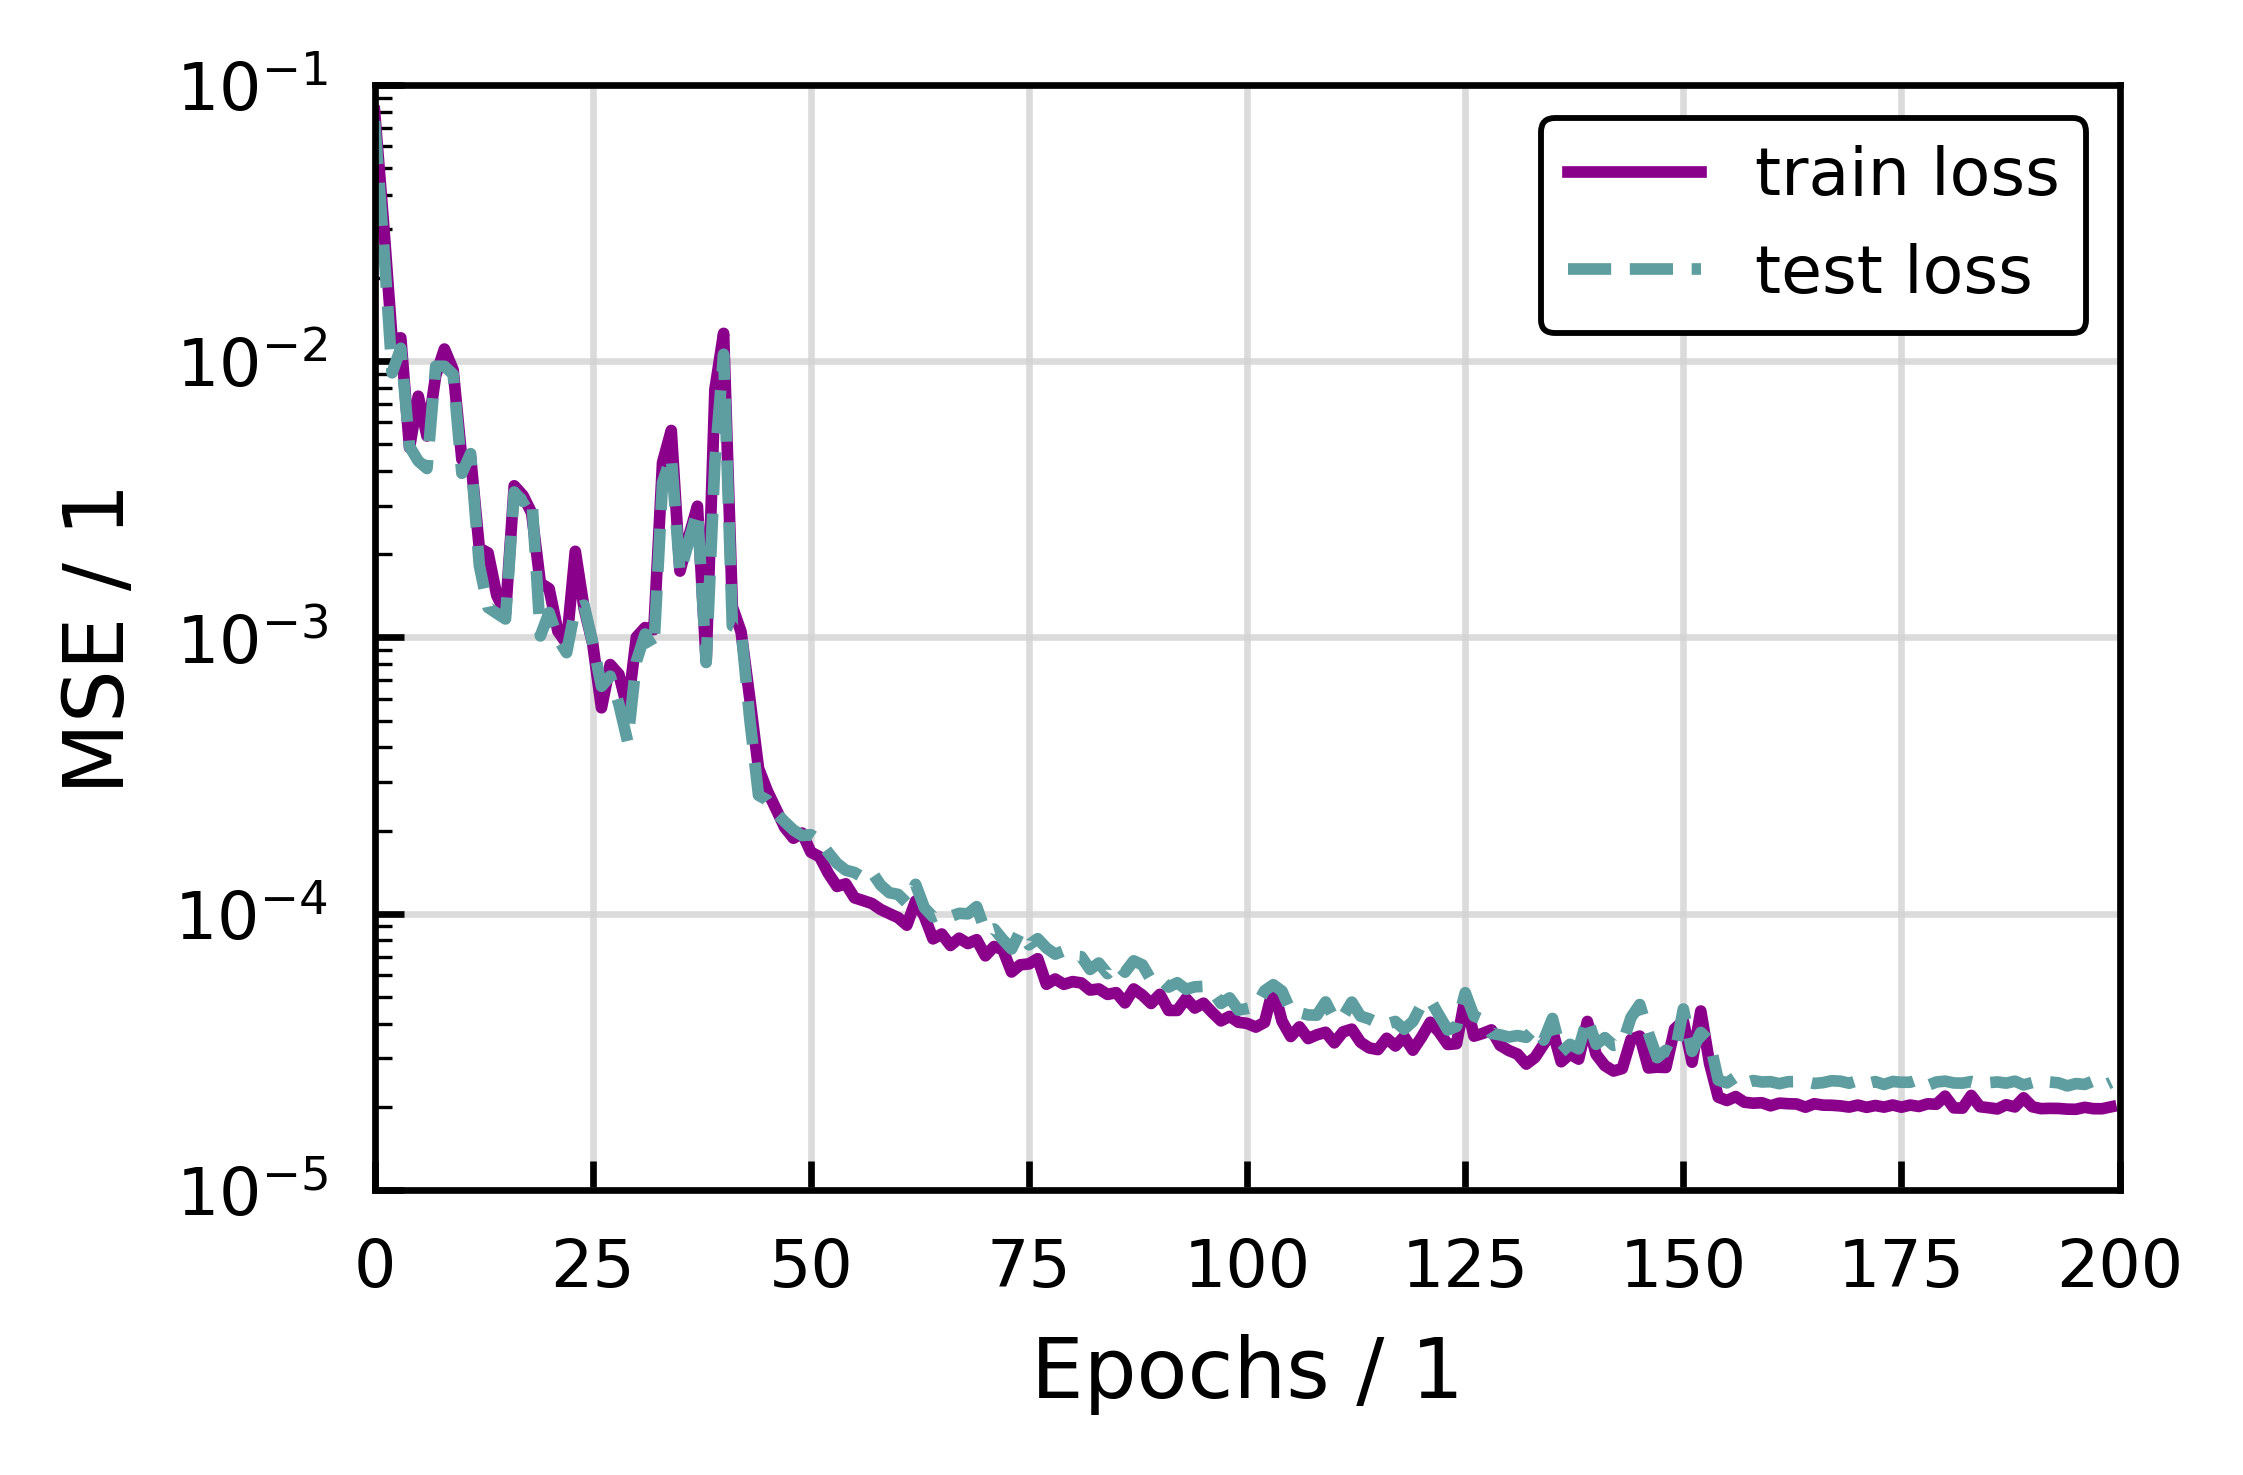

In [265]:
fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss,'--', label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = 'Epochs / 1', ylabel = 'MSE / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set(xlim=(0,200), ylim=(1e-5,1e-1))

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [266]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_001_learningcurve.png', bbox_inches = 'tight')

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999855857712625 , R^2(NH3) = 0.9999750424113059
Test Dataset: R^2(H2) = 0.9999736385359212 , R^2(NH3) = 0.9999722080583278
Max Error Training: |x_H2 - x_H2,pred| = 0.007723841464687409 , |x_NH3 - x_NH3,pred| = 0.003566265421604542
Max Error Test: |x_H2 - x_H2,pred| = 0.007624498862854212 , |x_NH3 - x_NH3,pred| = 0.0031976625030085276


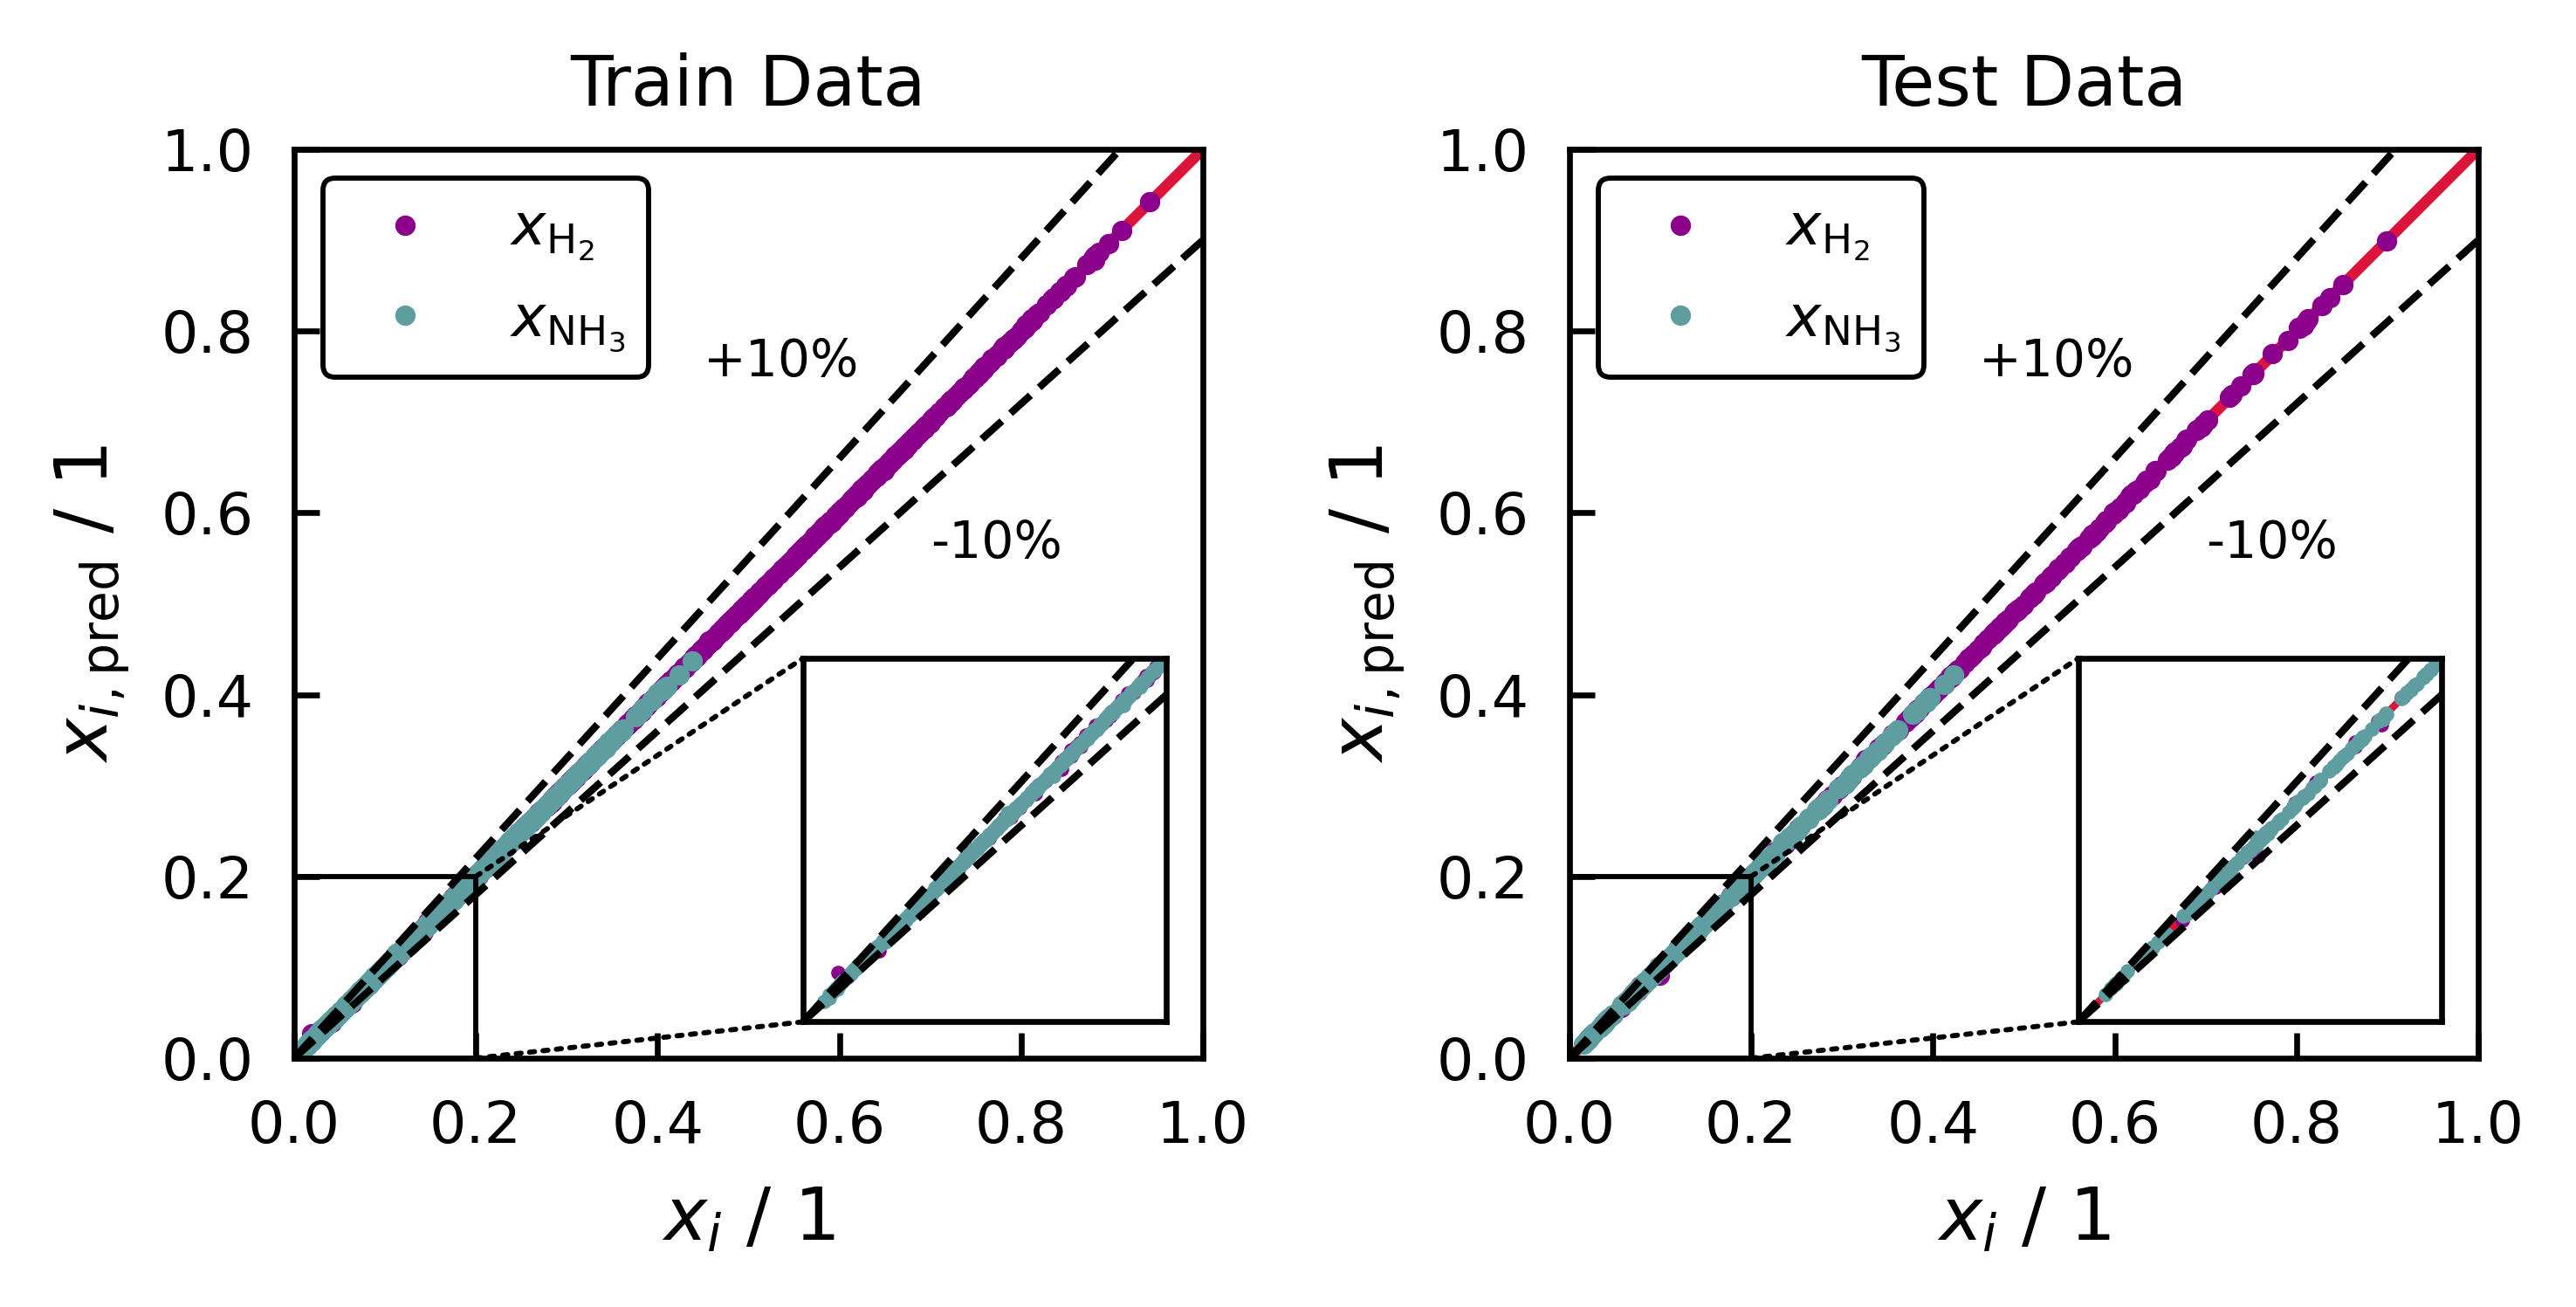

In [273]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2)#, figsize =(13*cm,6.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")


ax[0].plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "-", color = 'crimson',lw=1.5 ,transform=ax[0].transAxes, zorder=1)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax[0].text(0.45, 0.75, '+10%', fontsize=7)
ax[0].text(0.7, 0.55, '-10%', fontsize=7)
ax[0].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin0 = ax[0].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin0.plot(x_H2_real, x_H2_pred, '.', markersize = 4)
axin0.plot(x_NH3_real, x_NH3_pred, '.', markersize = 4)
axin0.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box2= ax[0].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[0].add_patch(cp1)
ax[0].add_patch(cp2)


# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "-", color = 'crimson',lw=1.5 ,transform=ax[1].transAxes, zorder=1)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line
ax[1].text(0.45, 0.75, '+10%', fontsize=7)
ax[1].text(0.7, 0.55, '-10%', fontsize=7)
ax[1].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax[1].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax[1].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[1].add_patch(cp1)
ax[1].add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [274]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_002_parity.png', bbox_inches = 'tight')

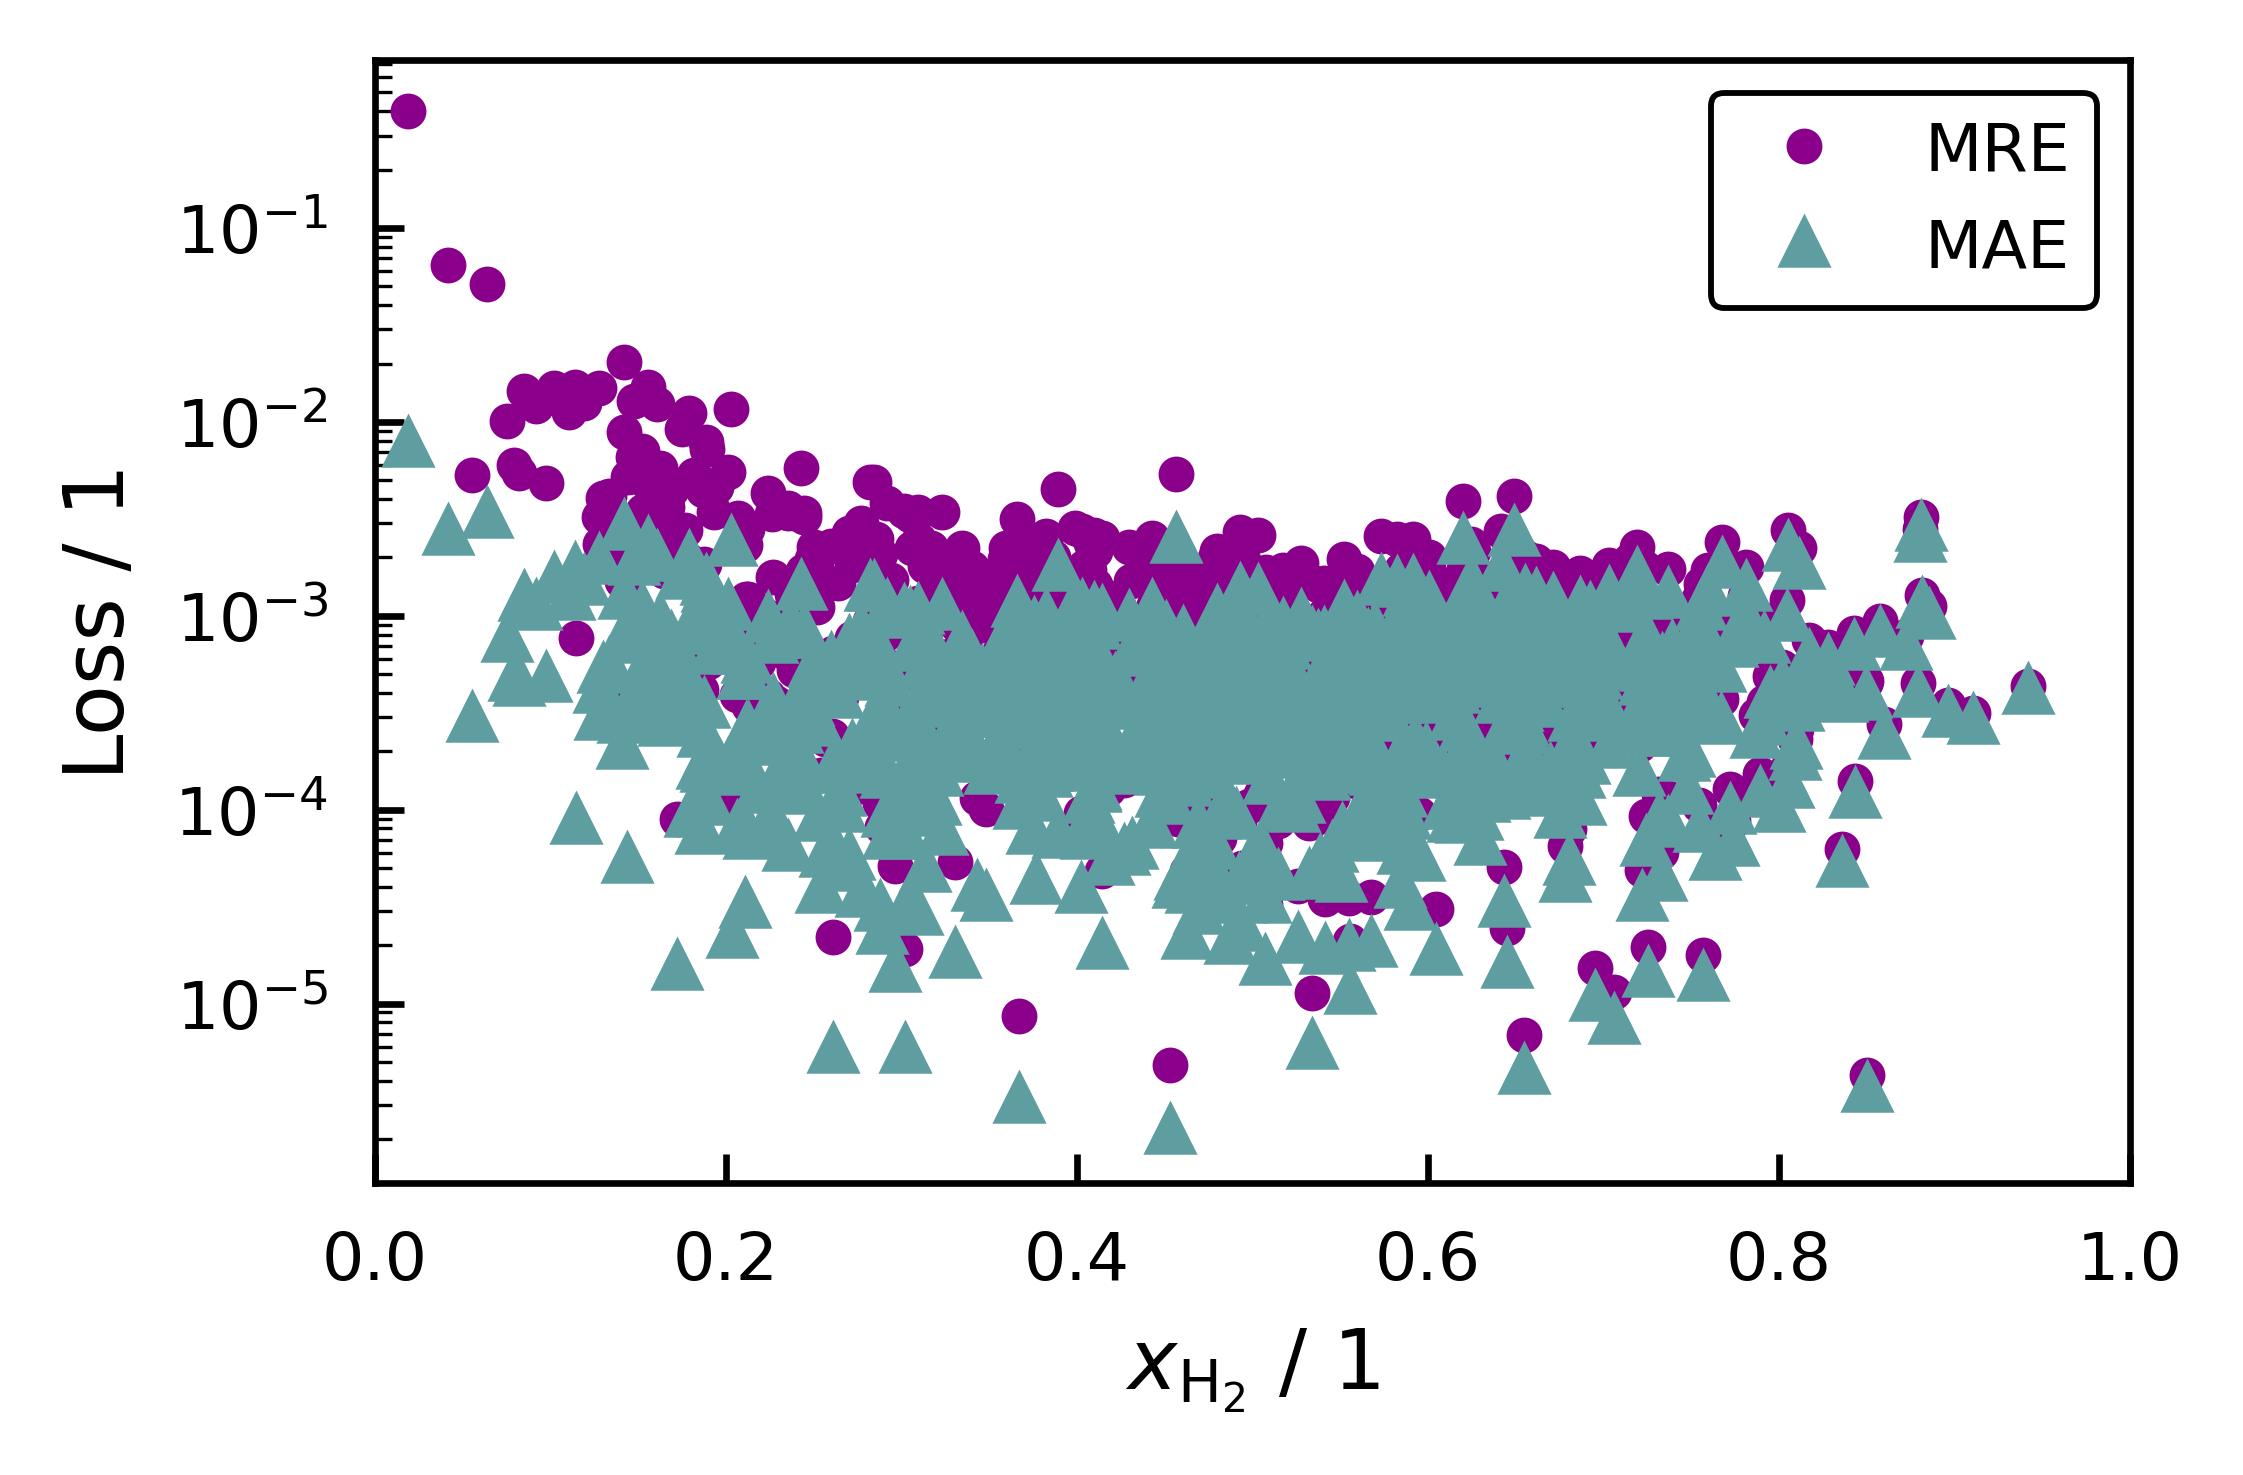

In [269]:
fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '^', markersize = 4, label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Loss / 1')
ax.set(xlim=(0,1))
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

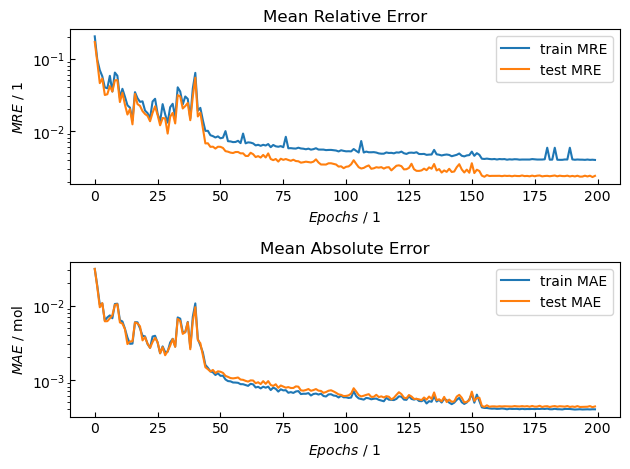

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

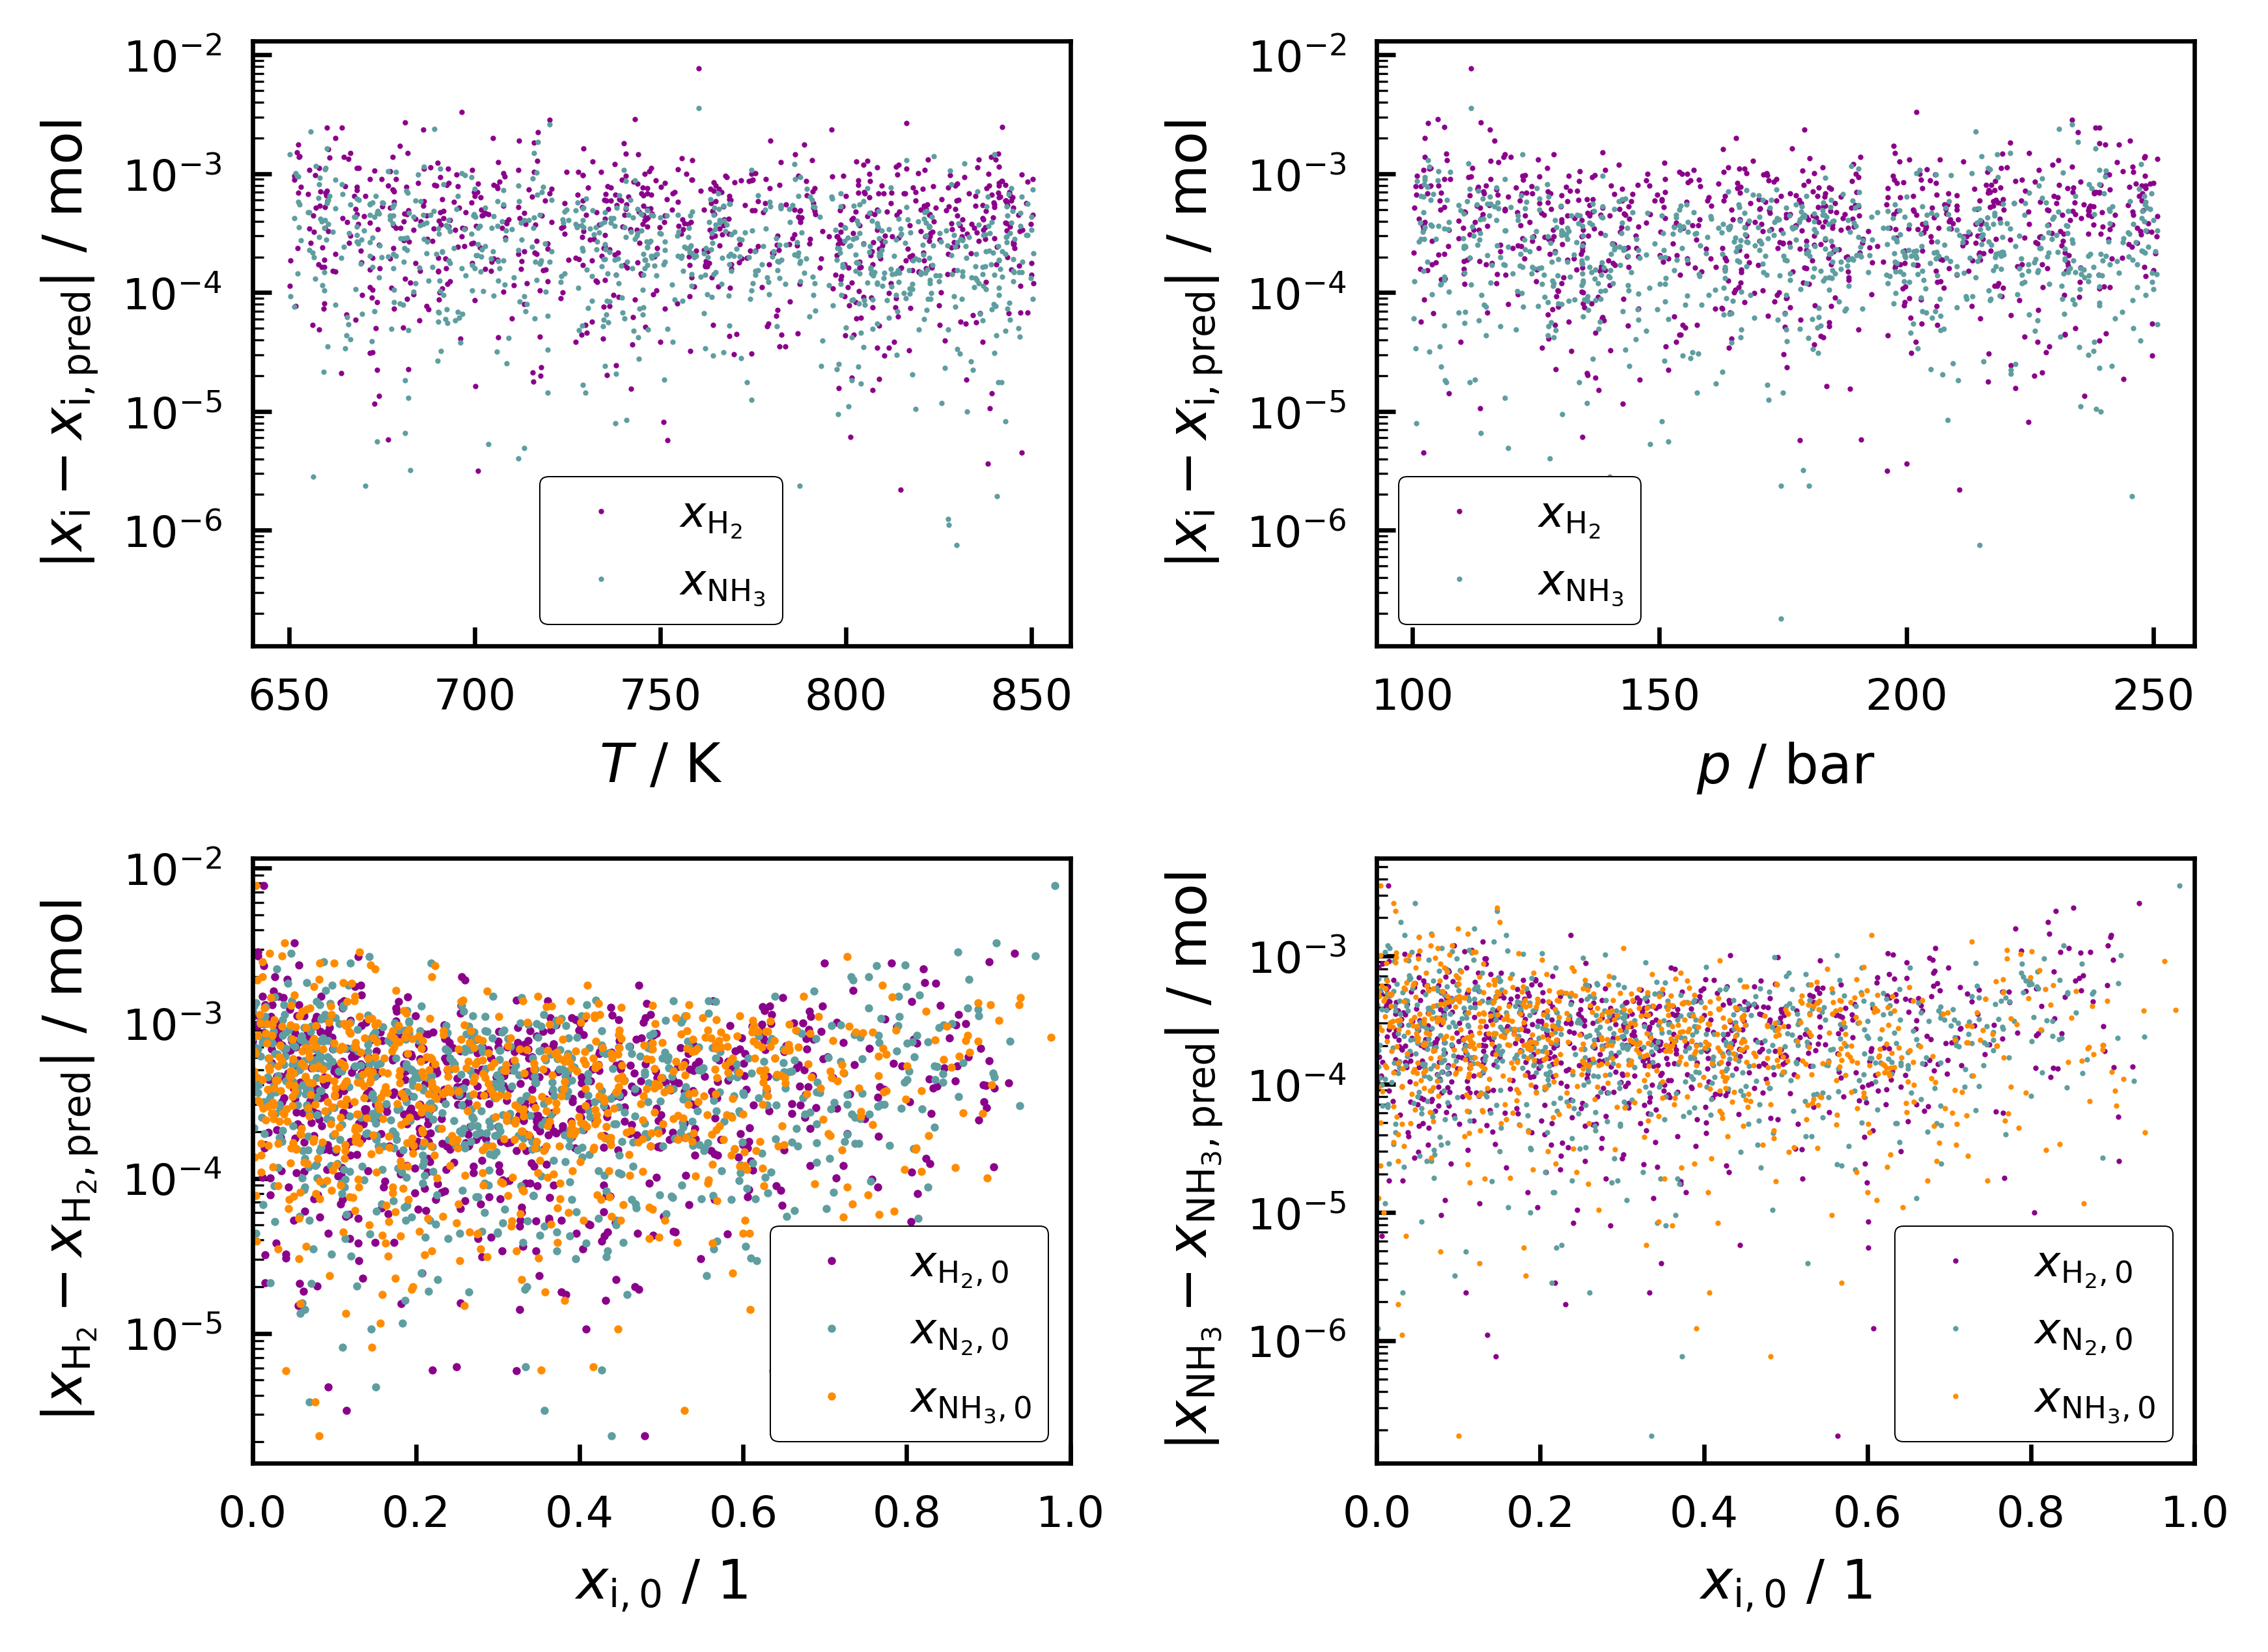

In [248]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (15*cm, 11*cm)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

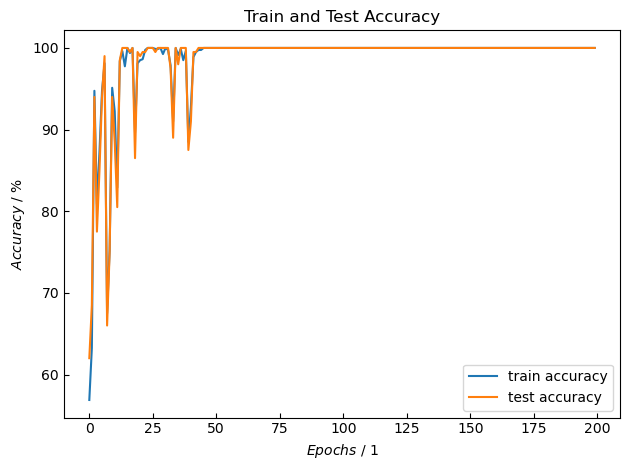

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.03125 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-6.6522e-01,  2.1857e-01,  1.1691e+00,  1.7808e-01, -1.3293e+00],
        [ 1.4035e+00,  5.9408e-01, -6.3031e-01, -9.4790e-01,  1.5874e+00],
        [ 9.9438e-01,  1.4025e+00,  1.3257e+00, -7.6355e-01, -5.2059e-01],
        [ 8.9255e-01,  1.3409e+00, -1.2877e+00,  7.3924e-01,  5.0819e-01],
        [-1.5485e+00,  2.6793e-01,  2.2703e+00, -1.2167e+00, -9.8440e-01],
        [ 1.0378e+00, -2.1129e-01, -1.0994e+00,  1.8913e+00, -8.5414e-01],
        [ 9.0468e-01, -9.3573e-01, -1.0592e+00,  2.1913e+00, -1.2002e+00],
        [-1.2655e+00, -7.4428e-01,  4.2967e-03, -1.4751e-01,  1.4655e-01],
        [-1.4236e+00, -5.0433e-01, -3.5978e-01,  8.0920e-01, -4.7398e-01],
        [ 4.0743e-01, -1.6347e+00, -1.2822e-01,  4.8525e-01, -3.7012e-01],
        [-1.2218e+00,  3.9974e-01, -1.1886e-01, -8.2186e-01,  9.5665e-01],
        [ 1.3465e-01, -4.4963e-01,  1.0341e+00, -9.4375e-01, -5.0226e-02],
        [ 8.7219e-01, -1.1286e+00, -9.8994e-01, -3.3050e-01,  1.3093e+00],
        [-1.2516e+00,  5.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-1.9419e-02, -2.0762e-01,  3.0288e-01,  1.9080e-01, -1.1606e-01],
         [ 9.2675e-02,  7.0409e-02,  2.7092e-01, -5.6667e-02,  2.3560e-02],
         [ 3.2546e-02,  5.1015e-02,  3.0815e-01,  3.4854e-01, -2.8759e-01],
         [ 1.8276e-01, -6.4676e-02,  6.4724e-02, -1.5000e-01, -8.5281e-02],
         [-1.7380e-01, -1.8619e-01, -1.3633e-01, -1.6324e-01, -1.7045e-01],
         [ 3.0634e-01,  2.0934e-01, -2.2658e-01,  3.4154e-01,  5.3989e-02],
         [-1.8857e-02, -1.0003e-01,  2.2295e-01, -7.5528e-02, -2.7326e-02],
         [ 1.4025e-01, -1.6450e-01, -4.2262e-02,  1.9954e-01, -3.1744e-02],
         [-4.0772e-01, -1.5347e-01, -2.0611e-01, -2.2758e-01,  4.8144e-02],
         [-3.7767e-01, -2.8047e-01, -2.8410e-01,  2.5205e-01, -2.9114e-01],
         [-4.4830e-01,  7.9037e-02,  2.1587e-01,  2.0712e-01,  4.1368e-01],
         [-8.9548e-02, -1.7775e-01, -1.1288e-01,  1.0857e-01, -3.4426e-01],
         [ 3.1694e-01,  2.1070e-01,  4.4358e-01,  2.7292e-01,  3.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.9922, 0.3119, 0.7634, 0.5386, 0.6125],
        [0.9792, 0.4581, 0.6064, 0.4927, 0.0134]])
tensor([[ 0.3964, -0.5285],
        [ 0.1698, -0.5222]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.4129e+00,  3.2659e-01, -1.2987e+00,  2.1592e+00, -9.3229e-01],
        [-1.4219e+00, -9.6435e-01, -1.3741e+00, -6.6880e-01,  2.0321e+00],
        [-8.1088e-01, -1.4258e+00,  1.7382e+00, -7.5496e-01, -9.3421e-01],
        [ 2.2295e-01,  1.4017e+00,  2.4954e-01,  6.1979e-01, -8.7837e-01],
        [ 1.6188e+00,  9.8707e-01,  4.7918e-02,  5.4363e-01, -6.0266e-01],
        [ 5.6383e-02,  1.2625e+00,  2.1928e+00, -9.2533e-01, -1.2063e+00],
        [-1.4110e+00, -2.3123e-01, -6.5870e-01,  4.8277e-01,  1.5300e-01],
        [ 4.8476e-01,  7.3575e-01,  1.9435e+00, -7.3809e-01, -1.1529e+00],
        [-1.0254e+00,  1.4990e+00,  1.3003e+00,  5.4971e-02, -1.3323e+00],
        [ 1.1987e+00, -9.1626e-01, -8.9835e-01, -1.3440e+00,  2.2553e+00],
        [-1.4753e+00, -1.0971e-01, -8.1232e-02, -1.2307e-01,  2.0551e-01],
        [ 1.2847e-01, -1.3181e+00, -8.6613e-01, -9.3356e-01,  1.8042e+00],
        [ 7.5846e-01,  4.7586e-01,  1.0682e+00, -7.9016e-01, -2.4074e-01],
        [ 1.4621e+00, -3.

#### Histogramme Verteilung von $xi$ und $x{_i}$

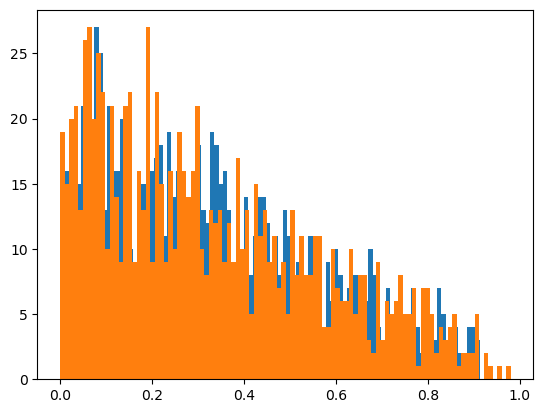

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [249]:
# torch.save(net.state_dict(),'data/models/ann_005_020.pth')
# np.savez('data/models/params_005_020.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)